In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, Flatten, Reshape, Conv2DTranspose, Convolution3D, MaxPooling3D, UpSampling3D, Conv3DTranspose
from tensorflow.keras import Model, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [26]:
class Encoder(layers.Layer):
    def __init__(self, intermediate_dim, latent_dim):
        super(Encoder, self).__init__()
        self.conv3d_1 = Convolution3D(filters=64, kernel_size=(3,3,3), kernel_initializer='he_normal', padding='same', activation='relu')
        self.mpooling3d_1 = MaxPooling3D((1,2,2), padding="same")
        
        self.conv3d_2 = Convolution3D(filters=128, kernel_size=(3,3,3), kernel_initializer='he_normal', padding='same', activation='relu')
        self.mpooling3d_2 = MaxPooling3D((3,2,2), padding="same")

        self.f = Flatten()
        self.d1 = Dense(units=intermediate_dim)
        self.d2 = Dense(units=latent_dim)
        self.d3 = Dense(units=latent_dim)

    def call(self, x):
        x = self.conv3d_1(x)
        x = self.mpooling3d_1(x)
        x = self.conv3d_2(x)
        x = self.mpooling3d_2(x)
        x = self.f(x)
        x = self.d1(x)
        mean = self.d2(x)
        logvar = self.d3(x)
        return mean, logvar
    
class ReparameterizationTrick(layers.Layer):
    def __init__(self):
        super(ReparameterizationTrick, self).__init__()
    def call(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        z = eps * tf.exp(logvar* .5) + mean
        return z

class Decoder(layers.Layer):
    def __init__(self, intermediate_dim):
        super(Decoder, self).__init__()
        self.d1 = Dense(units=intermediate_dim, activation='relu')
        self.d2 = Dense(units=80000, activation='relu')
        self.r = Reshape(target_shape=(1, 25, 25, 128))
        
        self.upsampling_1 = UpSampling3D((3, 2, 2))
        self.conv3dt_1   = Conv3DTranspose(128, (3,3,3), activation='relu', padding='same')
        self.upsampling_2 = UpSampling3D((1, 2, 2))
        self.conv3dt_2   = Conv3DTranspose(64, (3,3,3), activation='relu', padding='same')
        self.conv3dt_3   = Conv3DTranspose(1, (3,3,3), activation='relu', padding='same')

    def call(self, z):
        x = self.d1(z)
        x = self.d2(x)
        x = self.r(x)
        x = self.upsampling_1(x)
        x = self.conv3dt_1(x)
        x = self.upsampling_2(x)
        x = self.conv3dt_2(x)
        x = self.conv3dt_3(x)
        return x

class Autoencorder(Model):
    def __init__(self, intermediate_dim, latent_dim):
        super(Autoencorder, self).__init__()
        self.encoder = Encoder(intermediate_dim, latent_dim)
        self.decoder = Decoder(intermediate_dim)
        self.reparameterizationtrick = ReparameterizationTrick()
        
    def call(self, x):        
        mean, logvar = self.encoder(x)
        z = self.reparameterizationtrick(mean, logvar)
        reconstructed = self.decoder(z)
        return reconstructed

model = Autoencorder(500, 100)

In [27]:
optimizer = tf.keras.optimizers.Adam(1e-5)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
    z_mean, z_log_var = model.encoder(x)
    z = model.reparameterizationtrick(z_mean, z_log_var)
    x_decoded = model.decoder(z)
    xent_loss = tf.metrics.binary_crossentropy(x, x_decoded)
    xent_loss = tf.reduce_sum(xent_loss, axis=[1,2,3])
    
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return tf.reduce_mean(xent_loss + kl_loss)

#def compute_loss(model, x):
#    mean, logvar = model.encoder(x)
#    z = model.reparameterizationtrick(mean, logvar)
#    x_logit = model.decoder(z)   
#    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
#    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3,4])
#    logpz = log_normal_pdf(z, 0., 0.)
#    logqz_x = log_normal_pdf(z, mean, logvar)
#    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [28]:
@tf.function
def train_step(image):
     with tf.GradientTape() as tape:
        
        #ELBO
        loss = compute_loss(model, image)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)
        
@tf.function
def test_step(image):
    predictions = model(image)
    t_loss = tf.reduce_mean(tf.square(tf.subtract(predictions, image)))  
    test_loss(t_loss)

In [29]:
epochs = 1
batch_size =1

In [30]:
is_channels_first = False
if is_channels_first:
  buf = np.load('../Data/resnet3d_data_channel_first_updown_and_wipe_frame-3_stride123_gray_100x100_20191016.npz')

else:
  buf = np.load('../Data/resnet3d_data_channel_last_updown_and_wipe_frame-3_stride123_gray_100x100_20191016.npz')

X = buf["X"].astype("f4")
Y = buf["Y"]
del buf

#Y = keras.utils.to_categorical(Y, 2, dtype="f2").astype("f2")
X_train, X_val,  Y_train,  Y_val = train_test_split(X, Y, train_size=0.8, shuffle=False)
#X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, train_size=0.4, shuffle=True)

In [31]:
xtr = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
xte = tf.data.Dataset.from_tensor_slices(X_val).batch(batch_size)

In [32]:
for epoch in tqdm(range(epochs)):
    for image in xtr:
        train_step(image)

    for test_image in xte:
        test_step(test_image)

    template = 'Epoch {}, ELBO: {}'
    print(template.format(epoch+1, - train_loss.result(),))
#model.save_weights('VAE-3D_latent-100_epoch-500_weights.h5')

Epoch 1, ELBO: -16904.00390625



In [33]:
model.load_weights("VAE-3D_latent-100_epoch-500_weights.h5")

In [34]:
def PredictFromEncoder(model, input_data):
    meanArray = np.empty(shape=(1,100))
    varArray = np.empty(shape=(1,100))

    for image in input_data:
        buf1, buf2 = model.encoder(image)
    
        meanArray = np.block([[meanArray], [buf1]])
        varArray  = np.block([[varArray] , [buf2]])
    
    return meanArray, varArray

In [35]:
def Clustering(data):

    # K-meansによるクラスタリング
    kMeansModel = KMeans(n_clusters=2).fit(data)

    # PCAで次元削減
    pca = PCA(n_components=2)
    transformedData = pca.fit_transform(data)

    plt.figure()
    label0_count = 0
    label1_count = 0

    for (i, label) in enumerate(kMeansModel.labels_):
        if label == 0:
            plt.scatter(transformedData[i, 0], transformedData[i, 1], c="red")
            label0_count += 1
        elif label == 1:
            plt.scatter(transformedData[i, 0], transformedData[i, 1], c="blue")
            label1_count += 1

    print("label0_count = {}, label1_count = {}".format(label0_count, label1_count))
    plt.show()

label0_count = 235, label1_count = 258


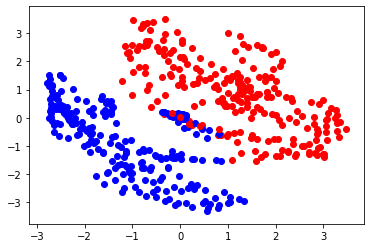

label0_count = 443, label1_count = 50


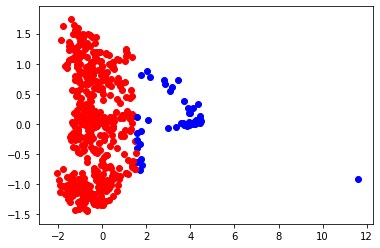

In [36]:
mA1, vA1 = PredictEncoder(model, xte)
Clustering(mA1)
Clustering(vA1)

label0_count = 492, label1_count = 1


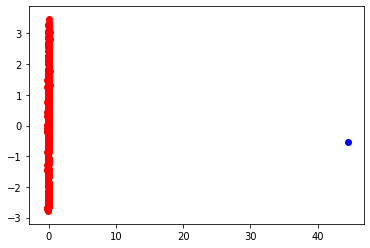

label0_count = 453, label1_count = 40


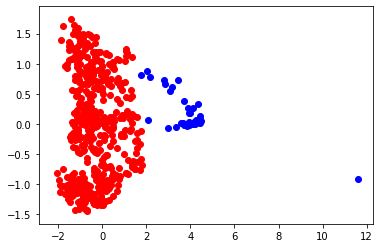

In [37]:
mA2, vA2 = PredictEncoder(model, xte)
Clustering(mA2)
Clustering(vA2)